### save it as html before submitting

In [79]:

import sqlite3
import os
import pandas as pd
import operator

# change to the directory where the files are stored
os.chdir("/Users/christopherpang/Desktop/Main/SIM uni year 2/Programming for data science/Coursework_data/dataverse_files")

try:
    os.remove('airline2.db')
except OSError:
    pass



# ======= create database =======
conn = sqlite3.connect('airline2.db')


#v2
data_frames = []

# Loop through the years from 1991 to 2000
for year in range(1990, 2001):
    # Construct the file path for the CSV file
    file_path = f"{year}.csv"
    
    # Read the CSV file into a DataFrame
    data = pd.read_csv(file_path)
    
    # Append the DataFrame to the list
    data_frames.append(data)

    
    
# adding all DataFrames in the list into a single DataFrame
ontime_df = pd.concat(data_frames, ignore_index=True, sort=False)
airports_df = pd.read_csv("airports.csv")
carriers_df = pd.read_csv("carriers.csv")
planes_df = pd.read_csv("plane-data.csv")
#print(ontime_df.head)


# ======= statistics summary =======
summaryAirports = airports_df.describe(include='all')
#print(summaryAirports)

summaryCarriers = carriers_df.describe(include='all')
#print(summaryCarriers)

summaryPlanes = planes_df.describe(include='all')
#print(summaryPlanes)

summaryOntime = ontime_df.describe(include='all')
#print(summaryOntime)

c = conn.cursor()
c.execute('''
CREATE TABLE ontime (
  Year int,
  Month int,
  DayofMonth int,
  DayOfWeek int,
  DepTime  int,
  CRSDepTime int,
  ArrTime int,
  CRSArrTime int,
  UniqueCarrier varchar(5),
  FlightNum int,
  TailNum varchar(8),
  ActualElapsedTime int,
  CRSElapsedTime int,
  AirTime int,
  ArrDelay int,
  DepDelay int,
  Origin varchar(3),
  Dest varchar(3),
  Distance int,
  TaxiIn int,
  TaxiOut int,
  Cancelled int,
  CancellationCode varchar(1),
  Diverted varchar(1),
  CarrierDelay int,
  WeatherDelay int,
  NASDelay int,
  SecurityDelay int,
  LateAircraftDelay int
)
''')
conn.commit()




for year in range(1991, 2000):
    ontime = pd.read_csv(str(year)+".csv")
    ontime.to_sql('ontime', con = conn, if_exists = 'append', index = False)

conn.commit()



# ======= creating planData Table =======
conn = sqlite3.connect('airline2.db')
c = conn.cursor()
c.execute("DROP TABLE IF EXISTS planData")

c.execute('''CREATE TABLE planeData (
  Tailnum varchar(6),
  Type varchar(25),
  Manufacturer varchar(25),
  Issue_date varchar(10),
  Model varchar(10),
  Status varchar(5),
  Aircraft_type varchar(25),
  Engine_type varchar(25),
  Year int 
      
)
''')


conn.commit()

# ======= getting the issue date of the planes that have less delays =======
planes_df.to_sql('planeData', con = conn, if_exists = 'append', index = False)

conn.commit()

planeNum=c.execute(''' SELECT Issue_date FROM planeData JOIN ontime ON planeData.Tailnum= ontime.Tailnum WHERE ArrDelay < '5' AND DepDelay < '5'
''').fetchall()

column_name1=["IssueDate"]
issueDatePd= pd.DataFrame(planeNum, columns= column_name1)


# ======= getting the deptime for flights that delay more than 15 mins  =======
timeOfDay= c.execute(''' SELECT DepTime AS DepTime FROM ontime 
                         WHERE ArrDelay > '15' AND DepDelay > '15' 
    
''').fetchall()

column_name=["DepTime"]
timeOfDayPd=pd.DataFrame(timeOfDay, columns= column_name)

        
       
   
    







        DepTime
0          1805
1          1102
2          1331
3          1359
4          1453
...         ...
5306897    0841
5306898    1355
5306899    1345
5306900    1001
5306901    2009

[5306902 rows x 1 columns]
143748
395391
492351
621530
667693
816450
922144
821877
338537
70399
13544
Best time of the day to fly is early morning from 0600 to 0800


## Answering Q2a) Best time of the day to fly for 1991 to 1999 (plotting delays)

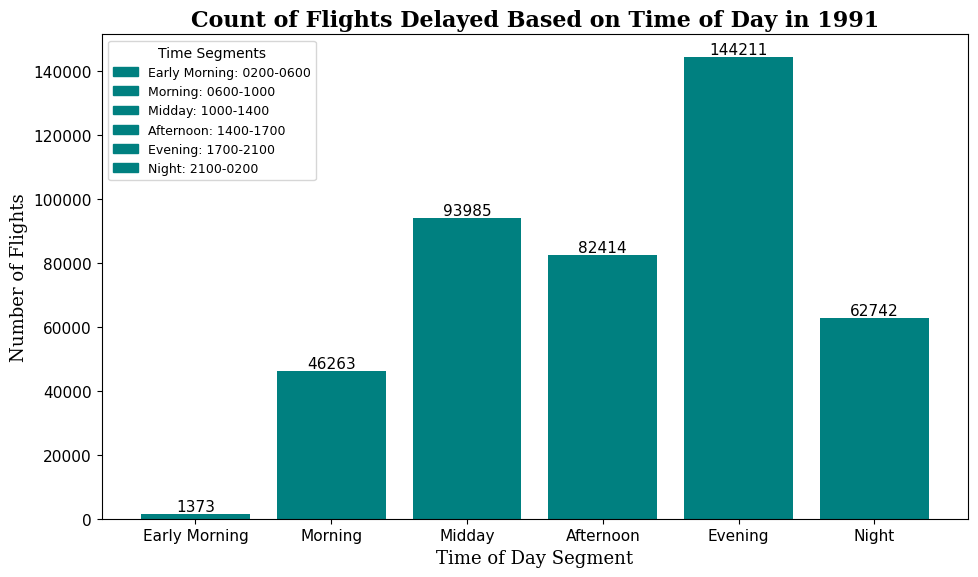

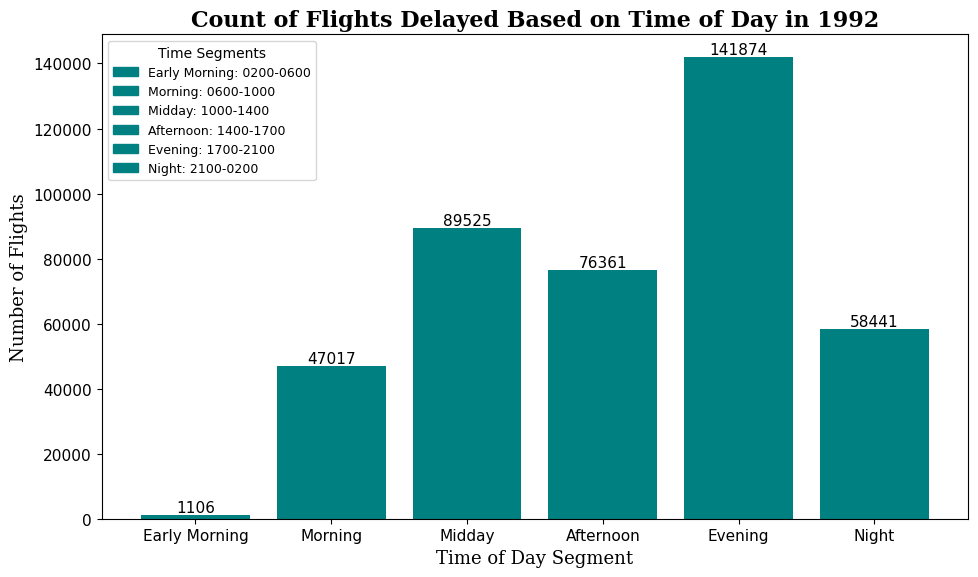

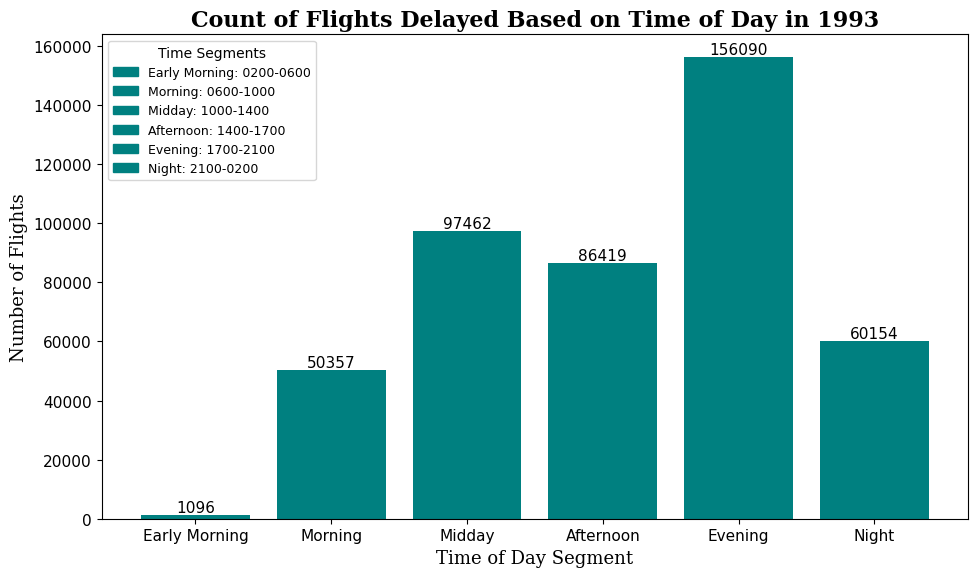

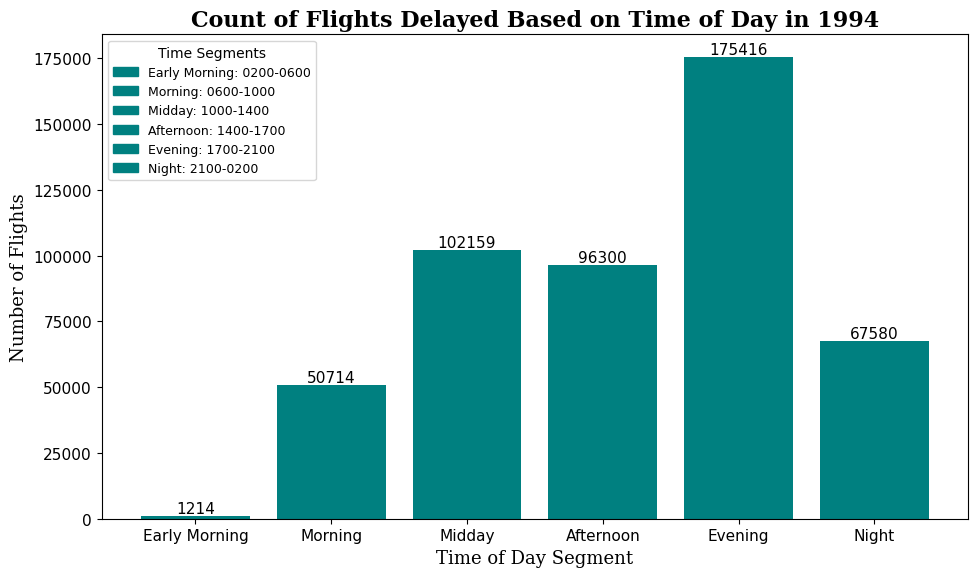

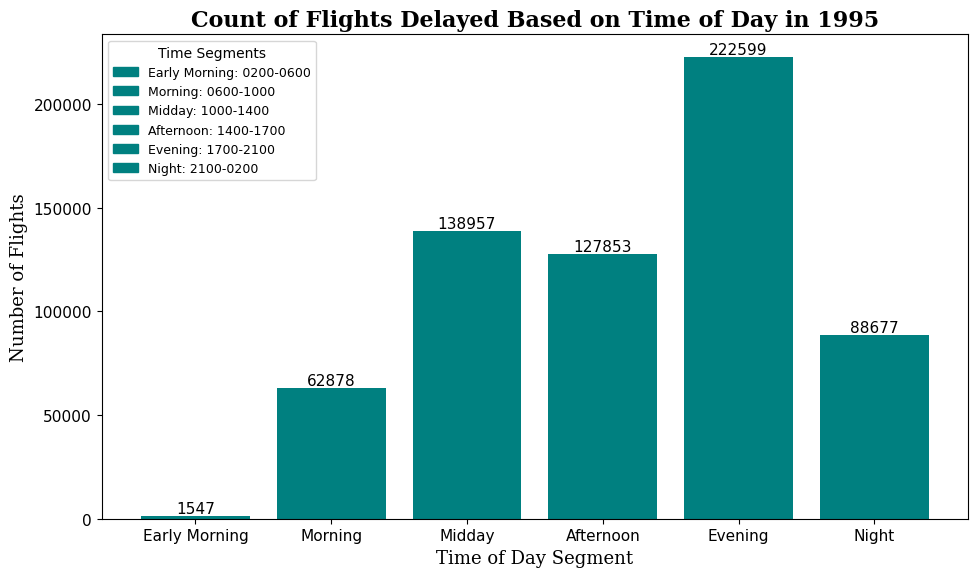

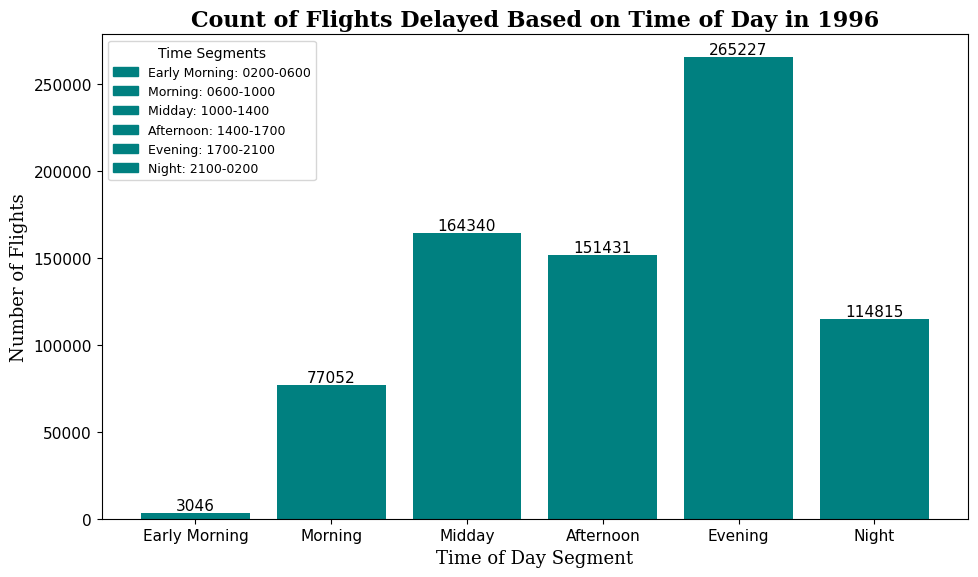

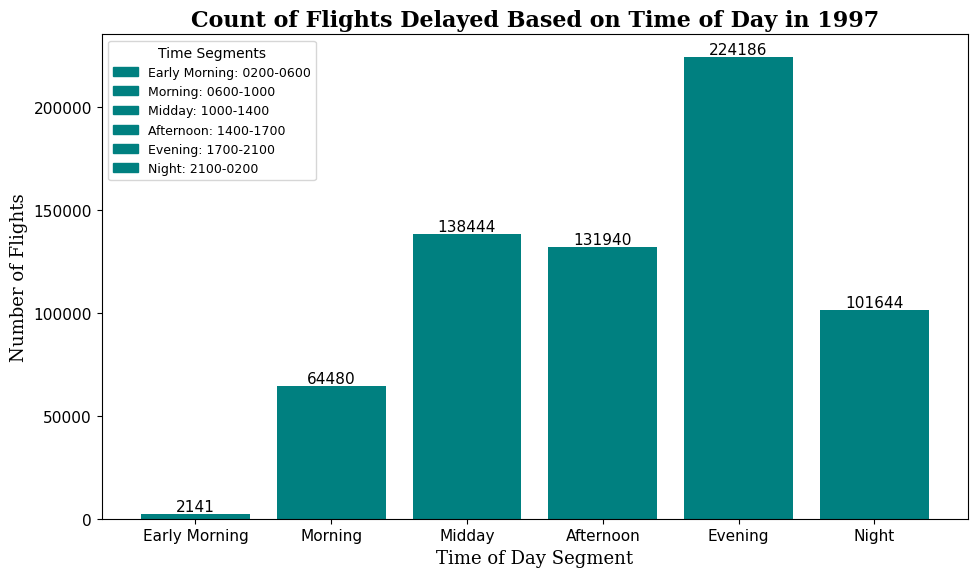

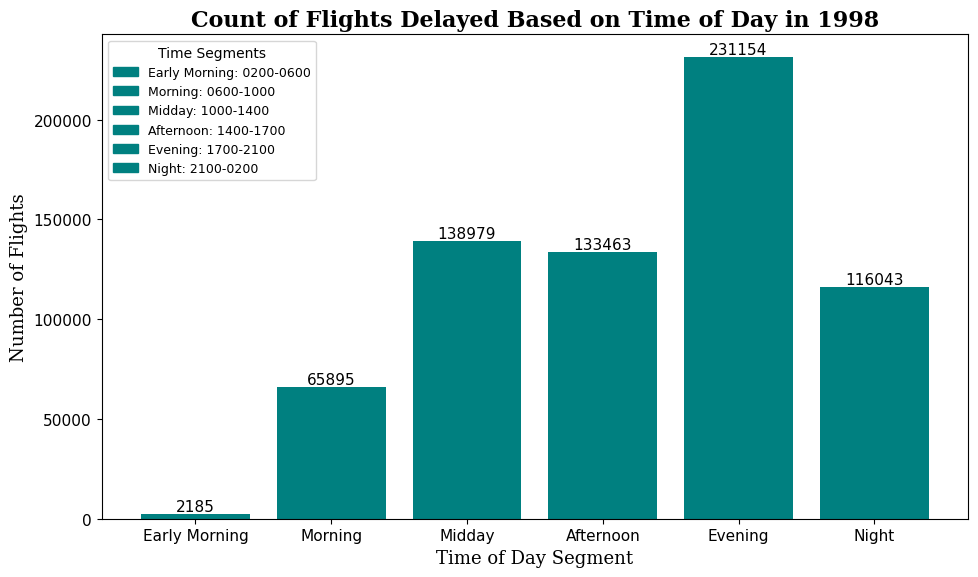

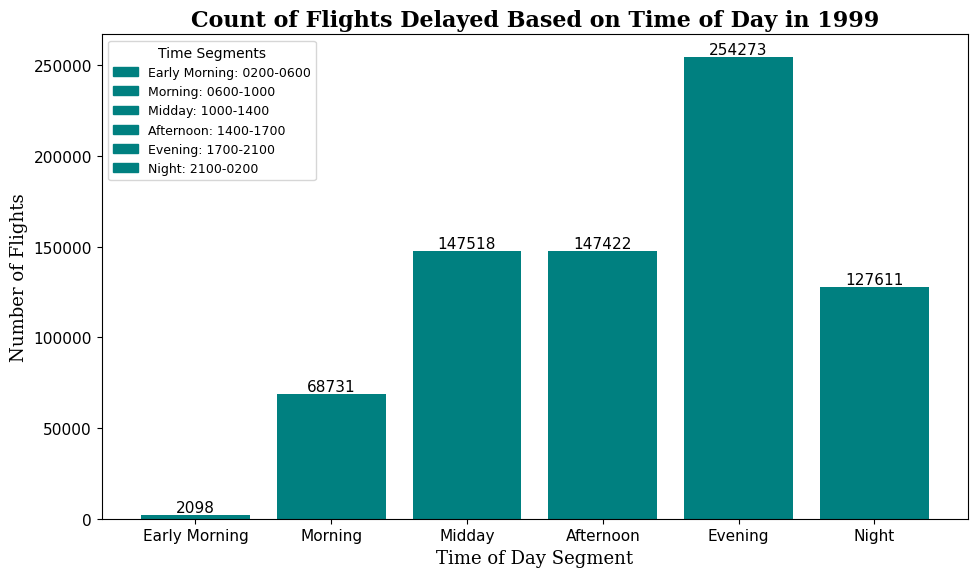

In [96]:
import matplotlib.patches as mpatches
# Initialize a dictionary to store each year's lowest delay count and corresponding segments
lowest_delay_counts_by_year = {}

def time_segment(deptime):
    """
    Categorize the departure time into segments of the day.
    
    Parameters:
    deptime (str): Departure time in "HHMM" format.
    
    Returns:
    str: The segment of the day.
    """
    # Extract hour from deptime and convert to an integer
    hour = int(deptime[:2])
    
    # Determine the segment based on the hour
    if 2 <= hour < 6:
        return 'Early Morning'
    elif 6 <= hour < 10:
        return 'Morning'
    elif 10 <= hour < 14:
        return 'Midday'
    elif 14 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'
    
for year in range(1991, 2000):
    query = f"""
    SELECT CAST(DepTime AS INTEGER) AS DepTime FROM ontime
    WHERE ArrDelay > 15 AND DepDelay > 15 AND Year = {year}
    """
    timeOfDayPd = pd.read_sql_query(query, conn)
    timeOfDayPd['DepTime'] = timeOfDayPd['DepTime'].apply(lambda x: f"{x:04d}")
    timeOfDayPd['Segment'] = timeOfDayPd['DepTime'].apply(time_segment)

    segment_order = ['Early Morning', 'Morning', 'Midday', 'Afternoon', 'Evening', 'Night']
    timeOfDayPd['Segment'] = pd.Categorical(timeOfDayPd['Segment'], categories=segment_order, ordered=True)
    segment_counts_ordered = timeOfDayPd.groupby('Segment').size()

    # Find the lowest delay count for time of the day for the year and store it
    min_delay_count = segment_counts_ordered.min()
    lowest_delay_segments = segment_counts_ordered.idxmin()  # Get the segment name with the lowest count
    lowest_delay_counts_by_year[year] = {'count': min_delay_count, 'segment': lowest_delay_segments}
    
     
    
    # Plotting
    plt.figure(figsize=(10, 6))
    bars = plt.bar(segment_counts_ordered.index, segment_counts_ordered.values, color='teal')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, int(yval), ha='center', va='bottom',fontsize= '11' )

        
    # Adjust the size of the numbers on the axes
    plt.xticks(range(len(segment_order)), segment_order, fontsize=11)  
    plt.yticks(fontsize=11)    
        
    # Define custom legend
    legend_labels_time_of_day = [
      "Early Morning: 0200-0600",
      "Morning: 0600-1000",
      "Midday: 1000-1400",
      "Afternoon: 1400-1700",
      "Evening: 1700-2100",
      "Night: 2100-0200"
      ]
   # Create custom legend handles
    legend_handles = [mpatches.Patch(color='teal', label=label) for label in legend_labels_time_of_day]

   # Create the custom legend
    plt.legend(handles=legend_handles, title="Time Segments", title_fontsize='10', loc='upper left', fontsize='9', handlelength=2)
    plt.title(f'Count of Flights Delayed Based on Time of Day in {year}', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'serif'})
    plt.xlabel('Time of Day Segment', fontdict={'fontsize': 13, 'family': 'serif'})
    plt.ylabel('Number of Flights', fontdict={'fontsize': 13, 'family': 'serif'})
    plt.xticks(rotation=360)  # Adjusted for better legibility
    plt.tight_layout()
    plt.show()



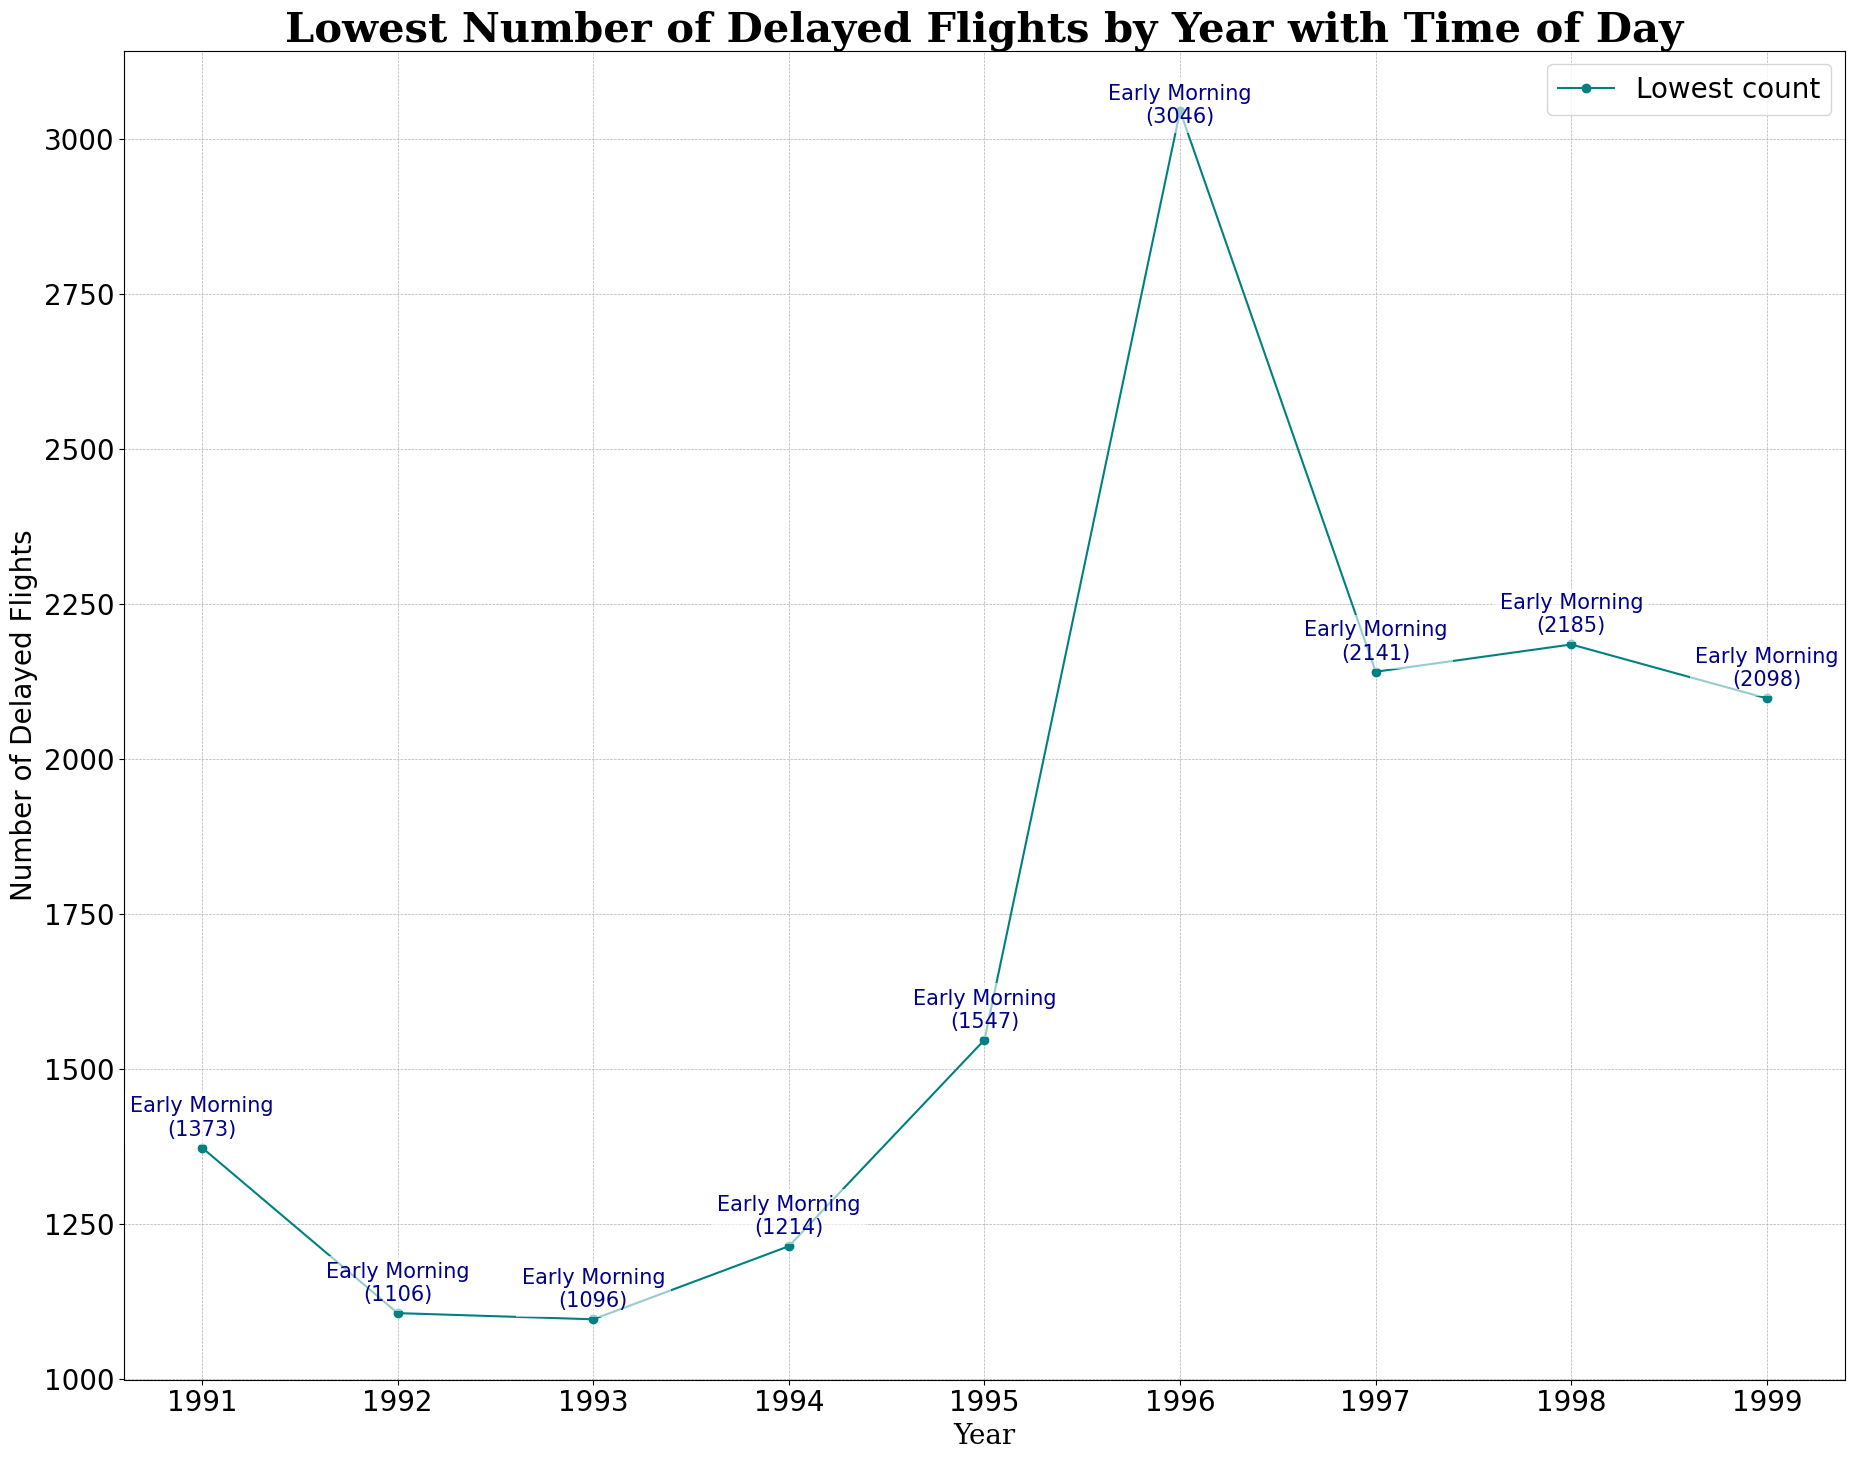

In [74]:


years = list(lowest_delay_counts_by_year.keys())
lowest_counts = [info['count'] for info in lowest_delay_counts_by_year.values()]
segments = [info['segment'] for info in lowest_delay_counts_by_year.values()]



plt.figure(figsize=(19, 15))
plt.plot(years, lowest_counts, marker='o', linestyle='-', color='teal', label='Lowest count')

# Determine the range of y-values to dynamically position text within the graph
y_min, y_max = min(lowest_counts), max(lowest_counts)
y_range = y_max - y_min
offset = y_range * 0.01  # Offset for text positioning, 5% of the y-range

# Plot adjustments to ensure text visibility and positioning within the graph
for i, (year, count, segment) in enumerate(zip(years, lowest_counts, segments)):
    # Calculate dynamic vertical position based on count value
    if count > y_max - offset:
        vertical_position = count - offset  # Move text down if too high
    else:
        vertical_position = count + offset  # Default: slightly above the point
    
    # Add the annotation with a consistent dark blue color and a white background box for visibility
    plt.text(year, vertical_position, f"{segment}\n({count})", 
             fontsize=15, ha='center',
             color='darkblue', bbox=dict( facecolor='white', alpha=0.6, edgecolor='none'))


    
plt.title('Lowest Number of Delayed Flights by Year with Time of Day',  fontdict={'fontsize': 30, 'fontweight': 'bold', 'family': 'serif'})
plt.xlabel('Year', fontdict={'fontsize': 20, 'family': 'serif'})
plt.ylabel('Number of Delayed Flights')
plt.xticks(years)
plt.yticks()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

plt.tight_layout()  # Adjust layout to fit all elements
plt.show()

## Answering Q2a) best day of the week to fly to minimize delays 

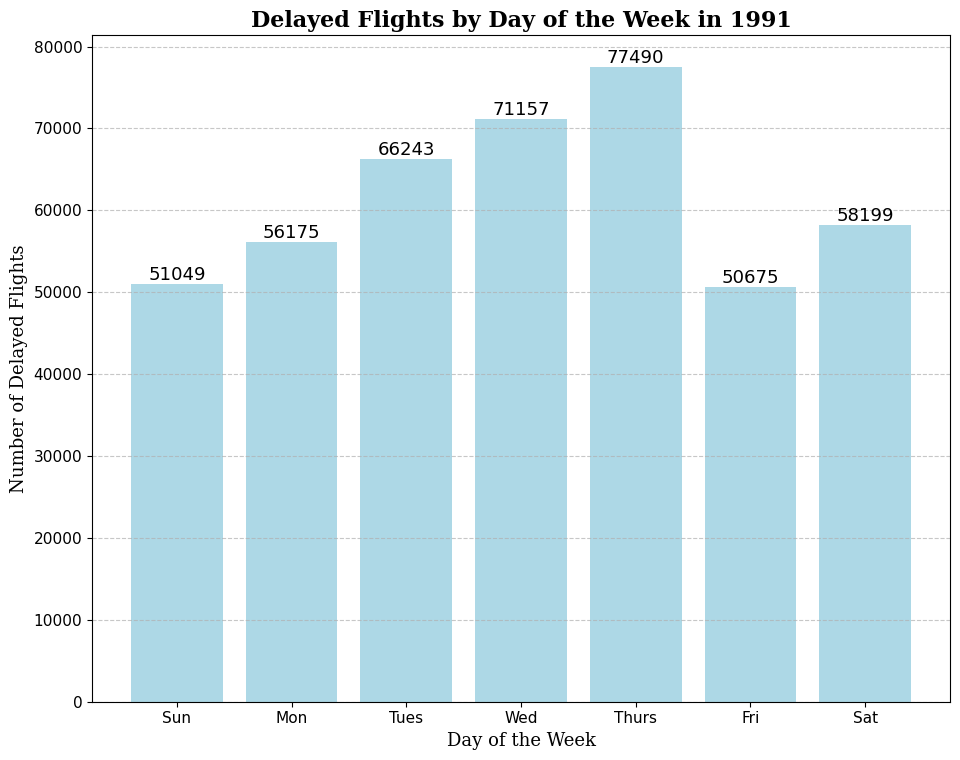

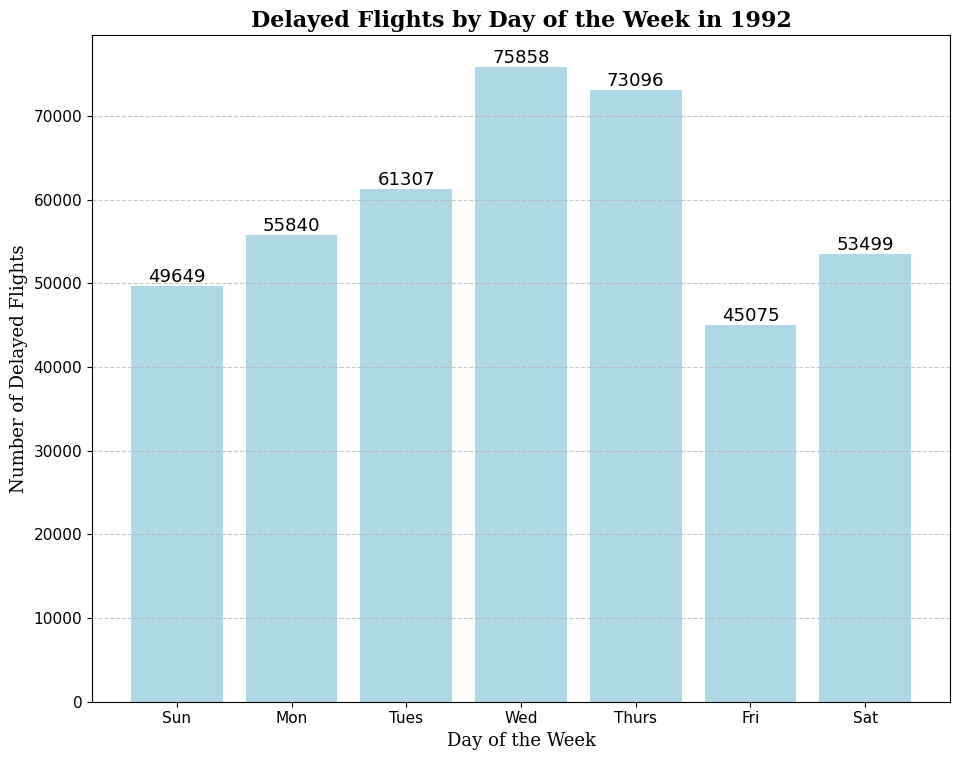

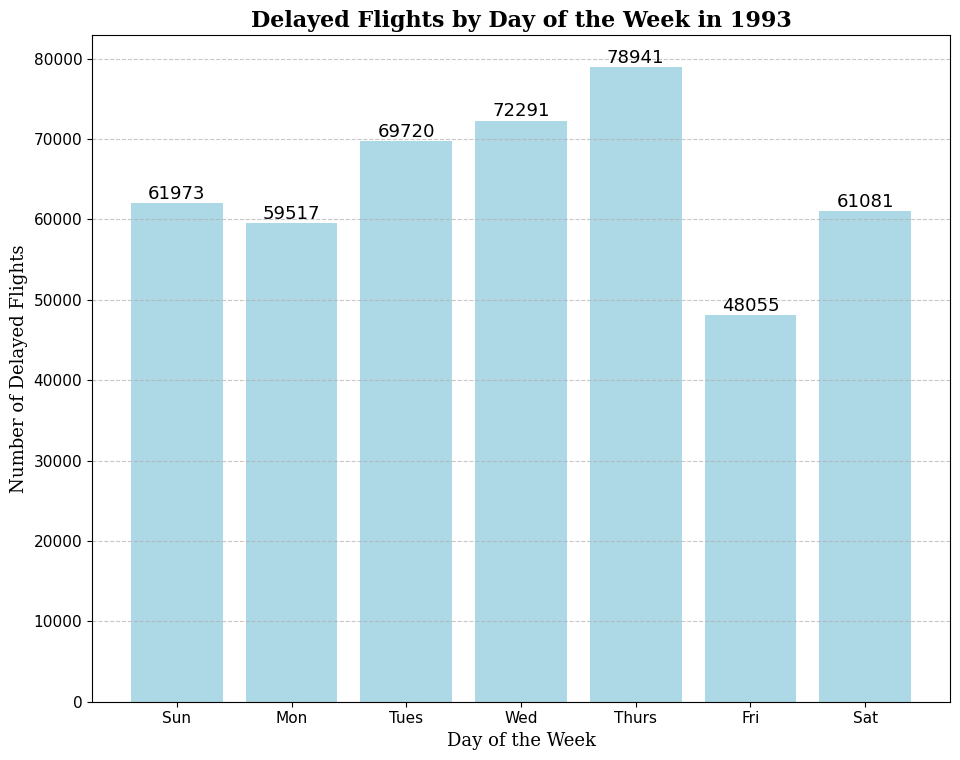

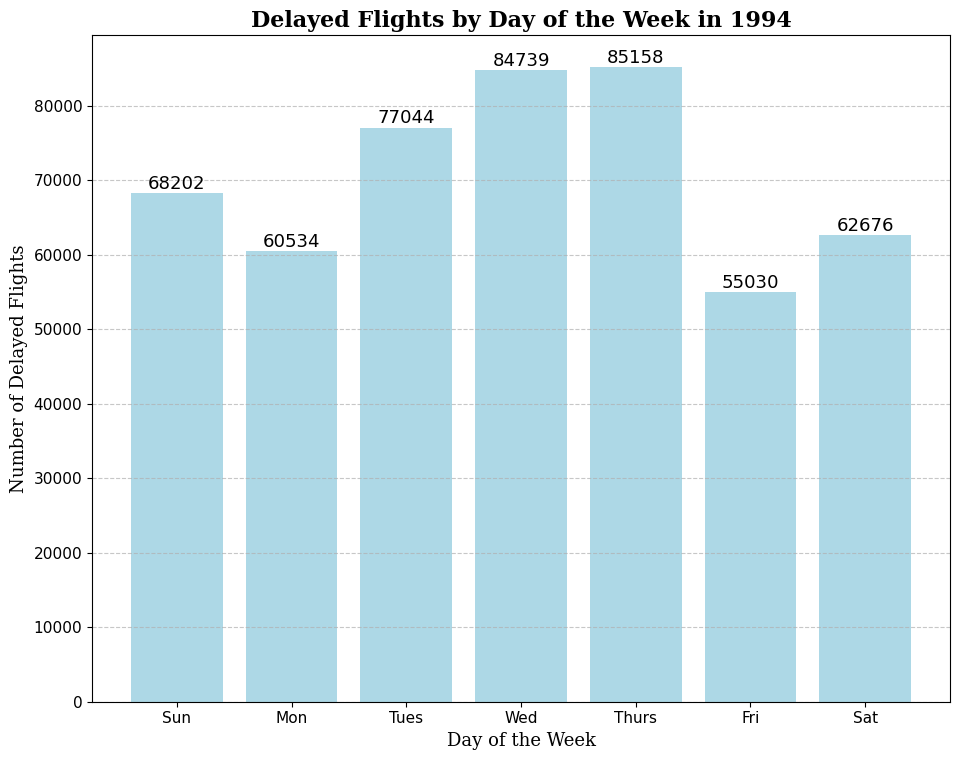

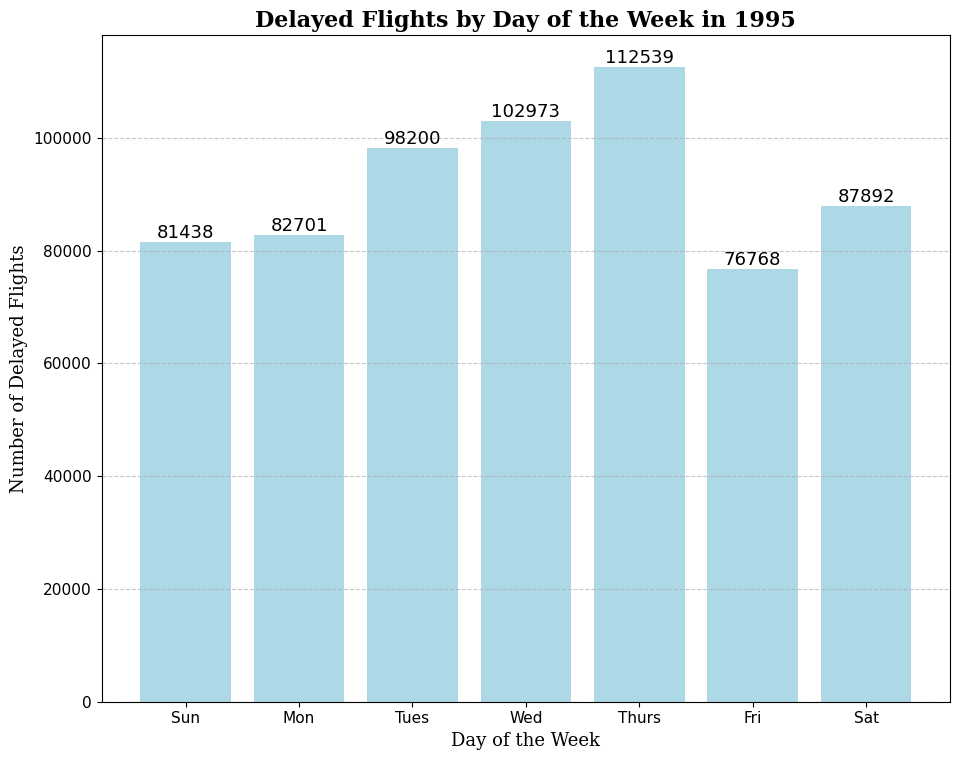

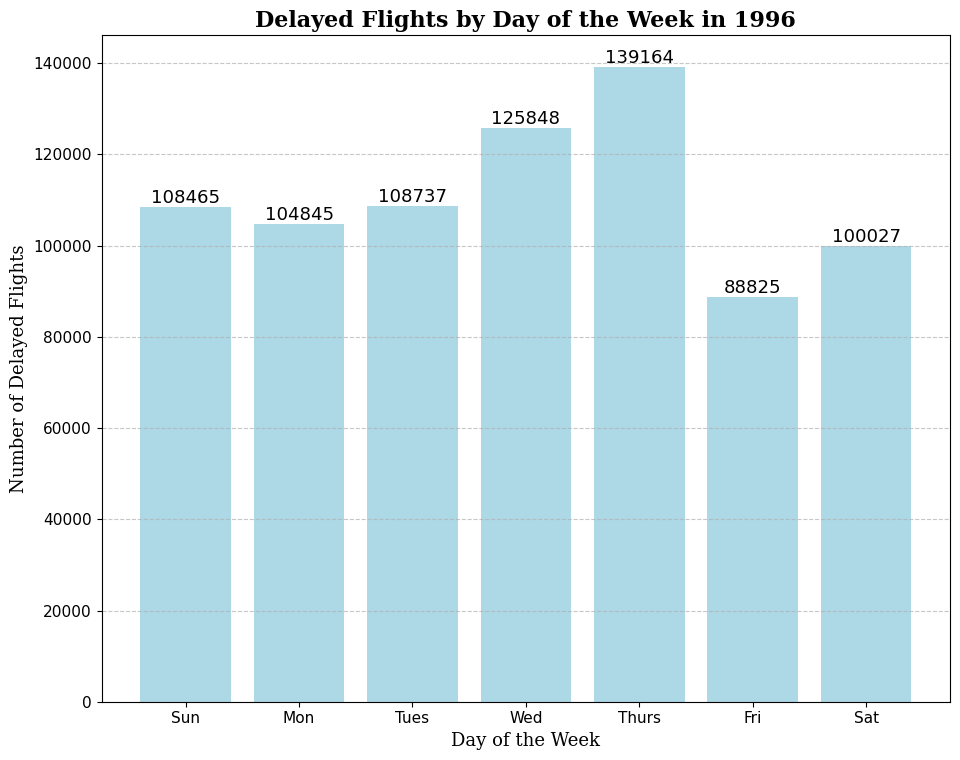

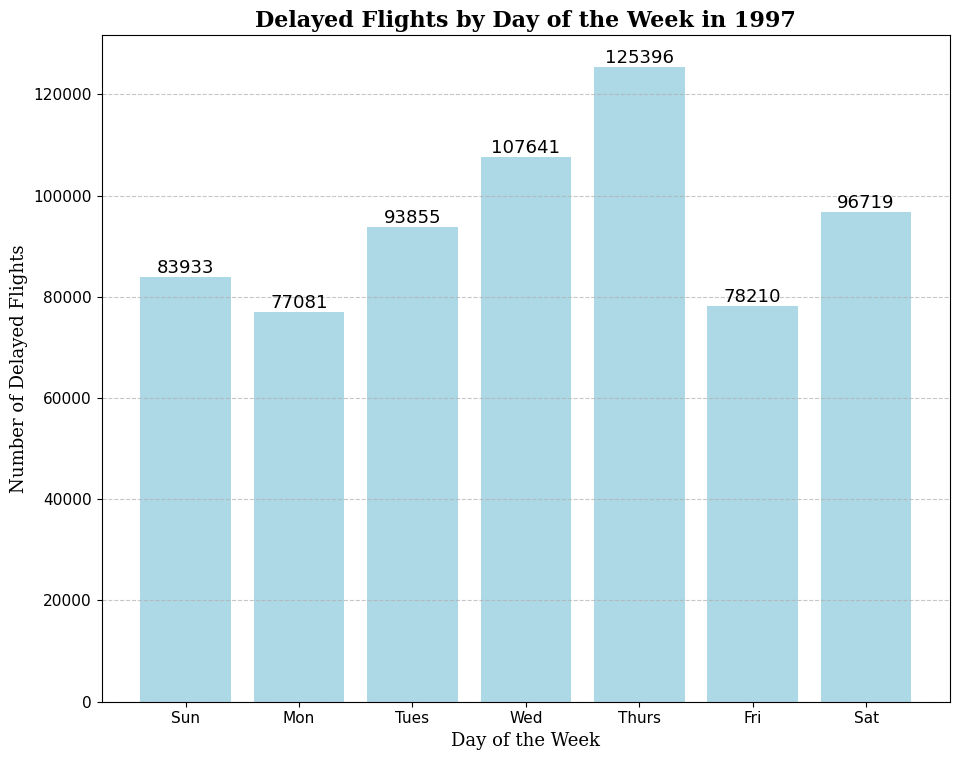

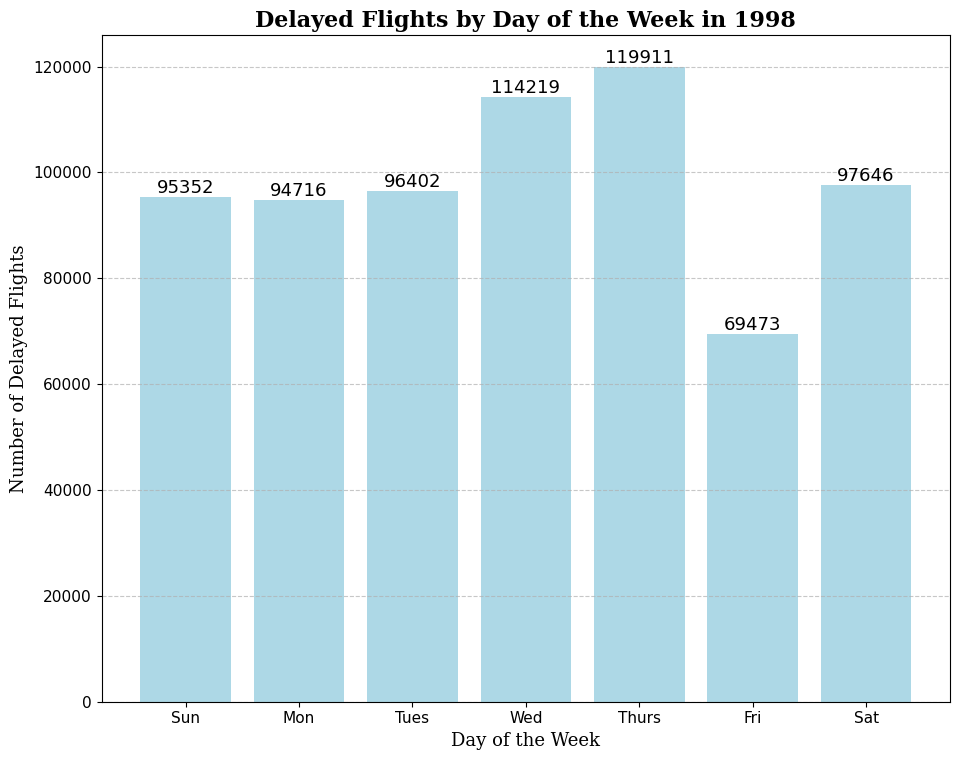

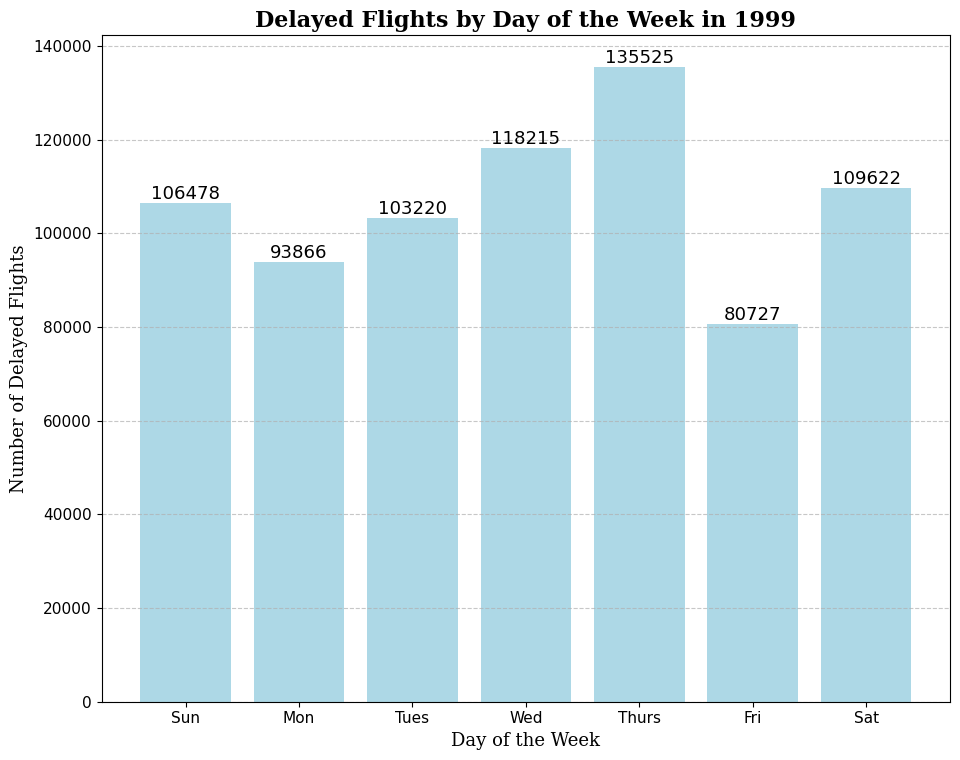

1991: Lowest delayed flights on Fri with 50675 delays.
1992: Lowest delayed flights on Fri with 45075 delays.
1993: Lowest delayed flights on Fri with 48055 delays.
1994: Lowest delayed flights on Fri with 55030 delays.
1995: Lowest delayed flights on Fri with 76768 delays.
1996: Lowest delayed flights on Fri with 88825 delays.
1997: Lowest delayed flights on Mon with 77081 delays.
1998: Lowest delayed flights on Fri with 69473 delays.
1999: Lowest delayed flights on Fri with 80727 delays.


In [92]:
# ======= Answering Q1b best day of the week to fly to minimize delays   =======
# Initialize a dictionary to store the day with the least delays for each year
lowest_delay_day_by_year = {}

for year in range(1991, 2000):
    query = f"""
    SELECT DayOfWeek, COUNT(*) AS Count 
    FROM ontime 
    WHERE Year = {year} AND ArrDelay > 15 AND DepDelay > 15 
    GROUP BY DayOfWeek
    ORDER BY DayOfWeek
    """
    dayOfWeekCounts = pd.read_sql_query(query, conn)
    
    # Initialize counts for all days to 0
    counts = [0]*7  # Assuming DayOfWeek is 1 (Sunday) to 7 (Saturday)
    for _, row in dayOfWeekCounts.iterrows():
        if 1 <= row['DayOfWeek'] <= 7:
            counts[row['DayOfWeek'] - 1] = row['Count']
    
    # Plotting a bar chart for each year
    plt.figure(figsize=(10, 8))
    tick_label = ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat']
    #colors = sns.color_palette("viridis", len(tick_label))
    plt.bar(range(len(counts)), counts, tick_label=tick_label, color='lightblue')
    
    # Adjust the size of the numbers on the axes
    plt.xticks(range(len(tick_label)), tick_label, fontsize=11)  
    plt.yticks(fontsize=11)  
    
    # Add data labels on top of each bar
    for i, count in enumerate(counts):
        plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=13)

    plt.xlabel('Day of the Week', fontdict={'fontsize': 13, 'family': 'serif'})
    plt.ylabel('Number of Delayed Flights', fontdict={'fontsize': 13, 'family': 'serif'})
    plt.title(f'Delayed Flights by Day of the Week in {year}', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'serif'})
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Store the day with the least delays for the year
    min_delay_count = min(counts)
    min_delay_day = tick_label[counts.index(min_delay_count)]
    lowest_delay_day_by_year[year] = {'Day': min_delay_day, 'Count': min_delay_count}

# Output the result for each year's lowest delay day
for year, info in lowest_delay_day_by_year.items():
    print(f"{year}: Lowest delayed flights on {info['Day']} with {info['Count']} delays.")

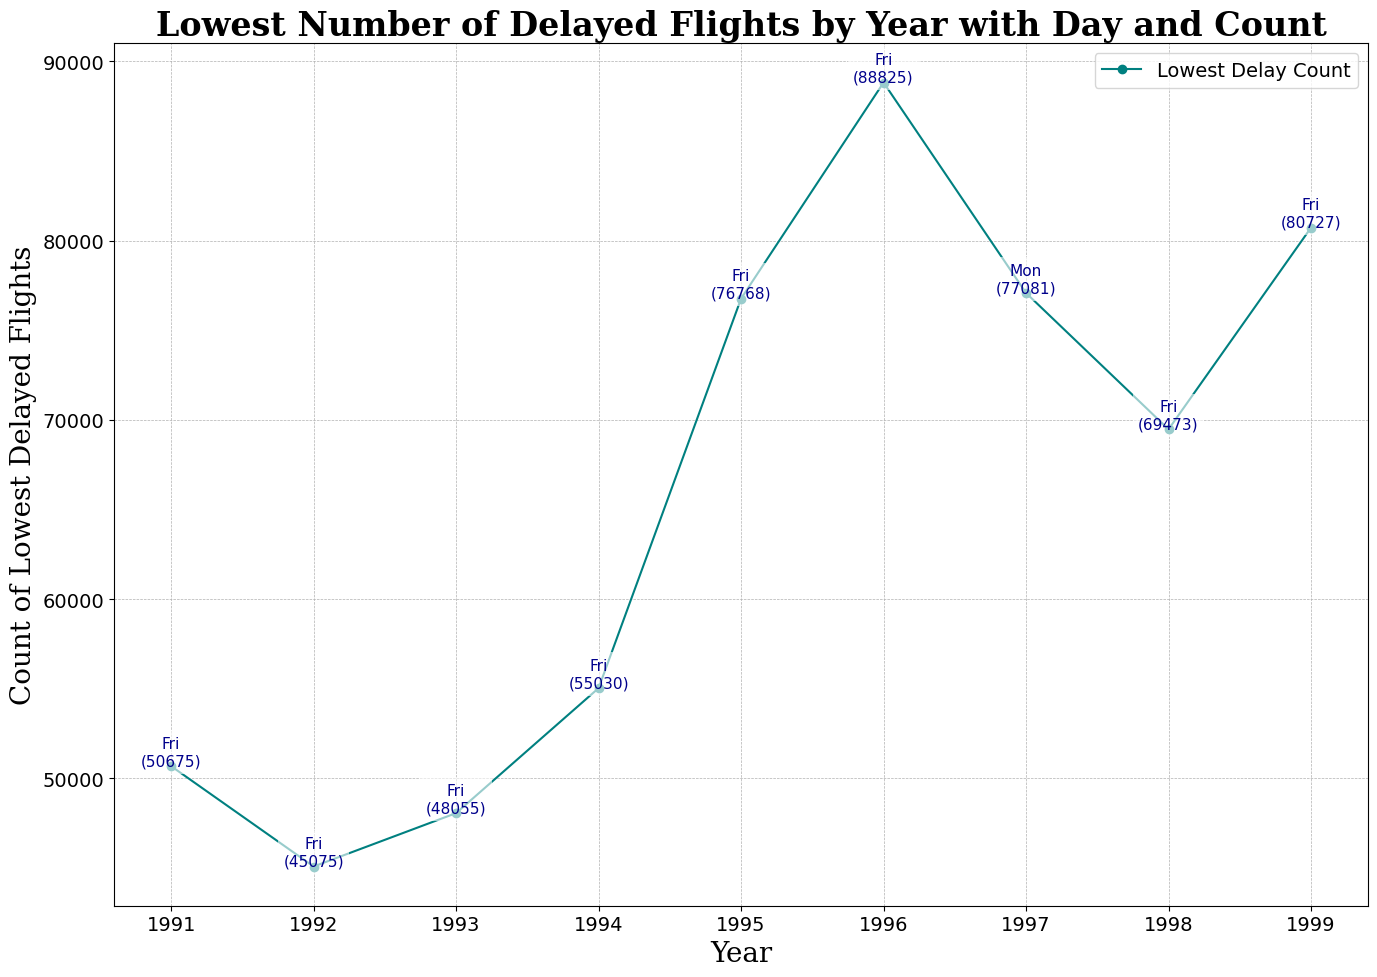

In [101]:


years = list(lowest_delay_day_by_year.keys())
lowest_counts = [info['Count'] for info in lowest_delay_day_by_year.values()]
lowest_days = [info['Day'] for info in lowest_delay_day_by_year.values()]

#plt.rcParams.update({'font.size': 14})  # Adjusting font size for readability

plt.figure(figsize=(14, 10))
plt.plot(years, lowest_counts, marker='o', linestyle='-', color='teal', label='Lowest Delay Count')

for i, (year, count, day) in enumerate(zip(years, lowest_counts, lowest_days)):
    # Adjusting vertical position for annotation
    vertical_position = count + (max(lowest_counts) - min(lowest_counts)) * 0.001
    # Annotation with both day and count
    annotation_text = f"{day}\n({count})"
    plt.text(year, vertical_position, annotation_text, fontsize=11, ha='center', color='darkblue', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.title('Lowest Number of Delayed Flights by Year with Day and Count', fontdict={'fontsize': 24, 'fontweight': 'bold', 'family': 'serif'})
plt.xlabel('Year', fontdict={'fontsize': 20, 'family': 'serif'})
plt.ylabel('Count of Lowest Delayed Flights', fontdict={'fontsize': 20, 'family': 'serif'})
plt.xticks(years)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()

plt.tight_layout()


## Answering question do older planes suffer more delays (old answer) 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



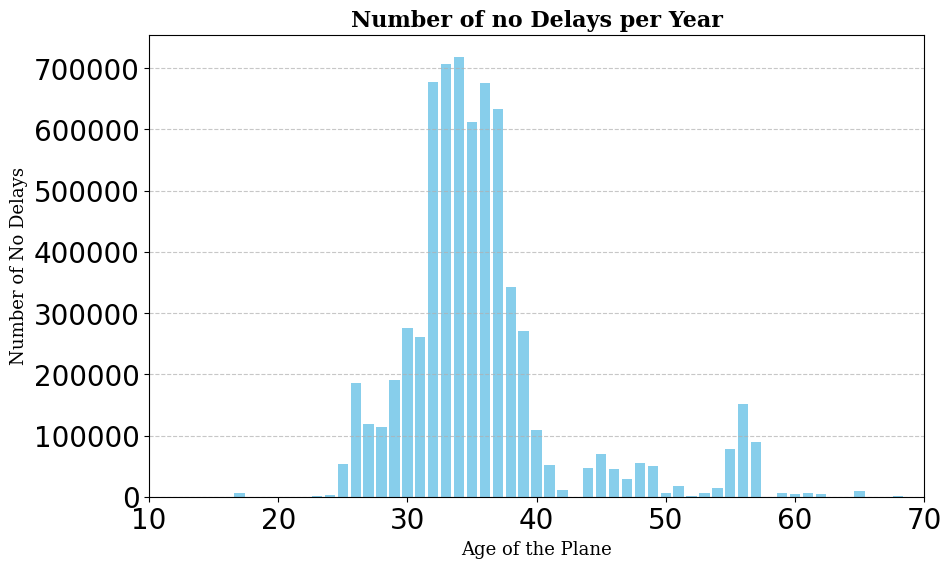

In [169]:
#Old code 
from matplotlib import pyplot as plt
# Fetch data from the database
dateOfPlane = c.execute('''
    SELECT CAST(planeData.year AS INTEGER) AS year
    FROM planeData
    JOIN ontime ON planeData.TailNum = ontime.TailNum
    WHERE CAST(ontime.ArrDelay AS INTEGER) < 15 AND CAST(ontime.DepDelay AS INTEGER) < 15 
    AND planeData.year IS NOT NULL
''').fetchall()
# Create a DataFrame
column_name = ["Year"]
datesOfPlaneDp = pd.DataFrame(dateOfPlane, columns=column_name)

# Convert 'Year' column to integers and subtract from 2024
datesOfPlaneDp['Year'] = datesOfPlaneDp['Year'].apply(lambda x: 2024 - int(x) if isinstance(x, (int, str)) and str(x).isdigit() else x)

# Group by year and count the occurrences
delay_counts = datesOfPlaneDp['Year'].value_counts().sort_index()

# Plot the graph
plt.figure(figsize=(10, 6))
bars=plt.bar(delay_counts.index, delay_counts.values, color='skyblue')


    
# Labels and title
plt.title('Number of no Delays per Year', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'serif'})
plt.xlabel('Age of the Plane',  fontdict={'fontsize': 13, 'family': 'serif'})
plt.ylabel('Number of No Delays',  fontdict={'fontsize': 13, 'family': 'serif'})

#Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)



plt.xlim(10, 70) 


plt.show()



## Q2a) Answering question do older planes suffer more delays (new code)

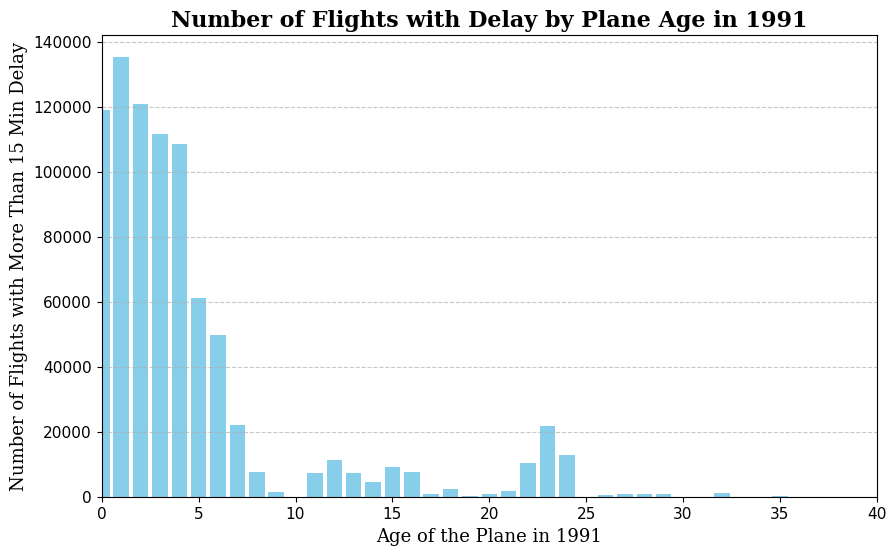

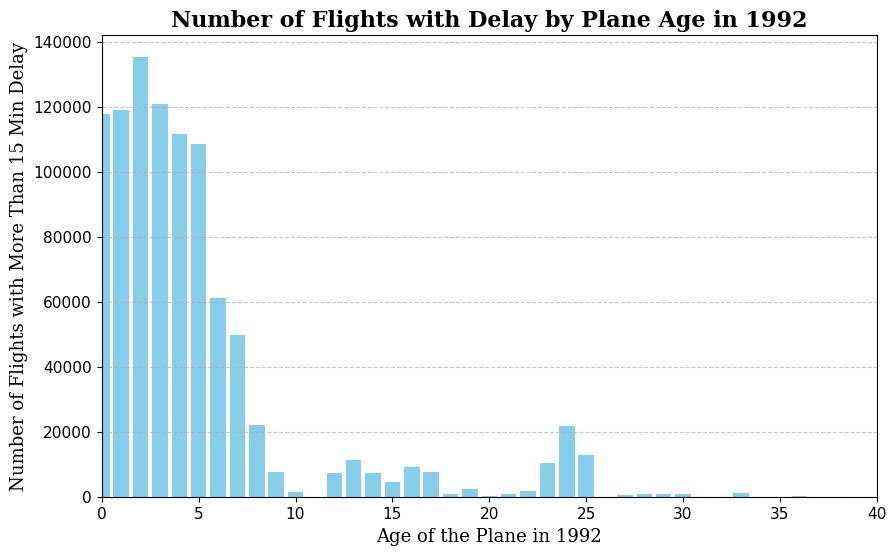

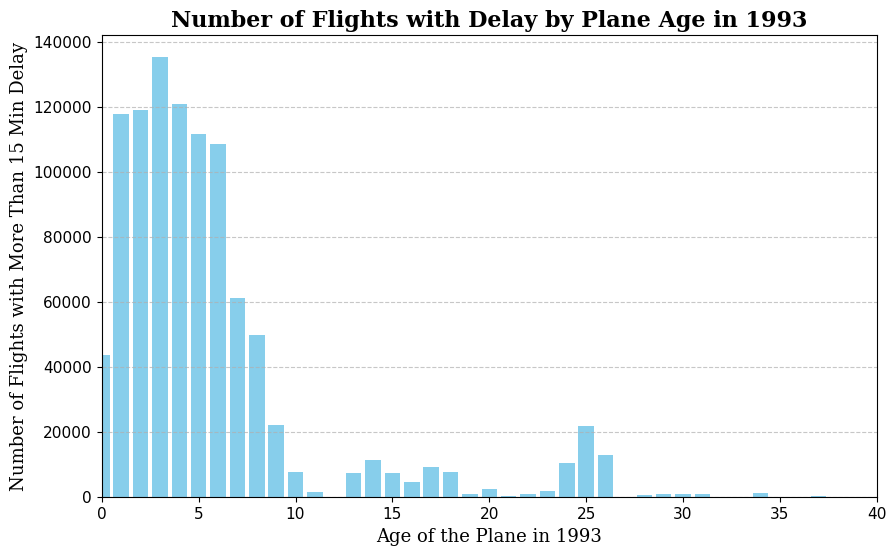

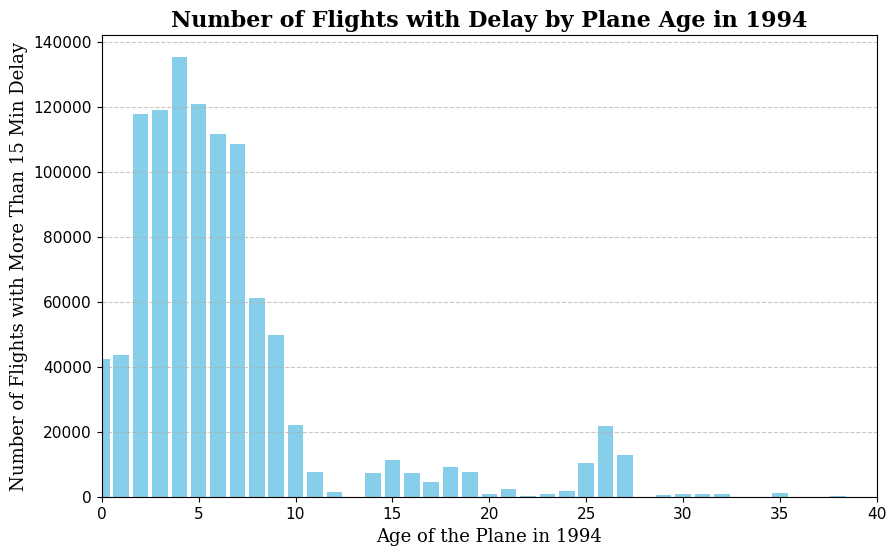

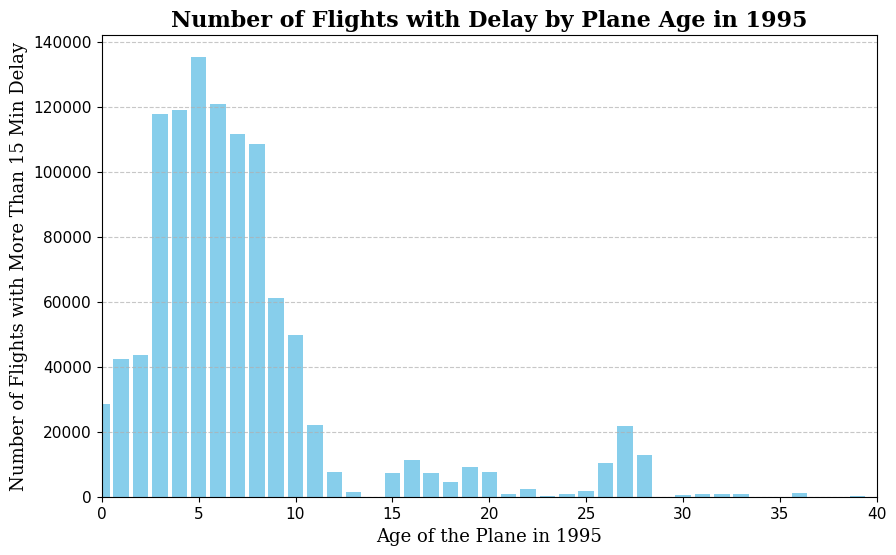

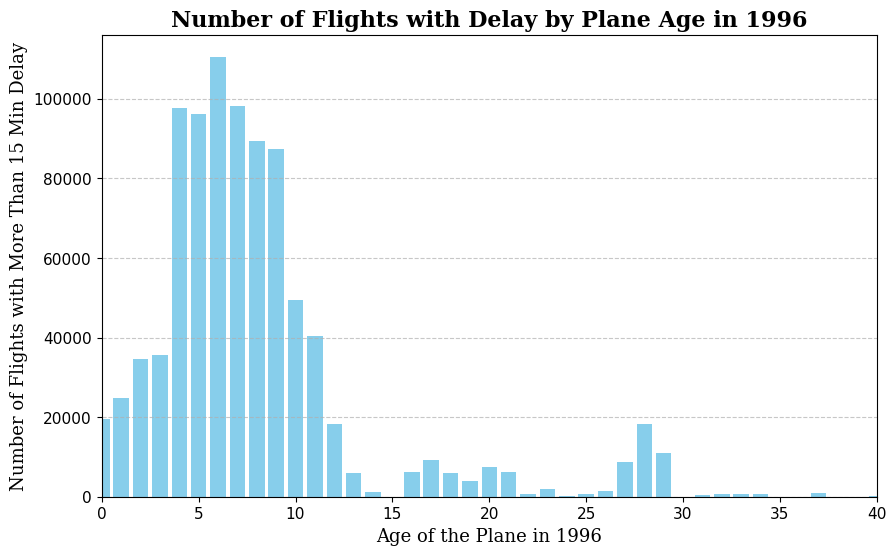

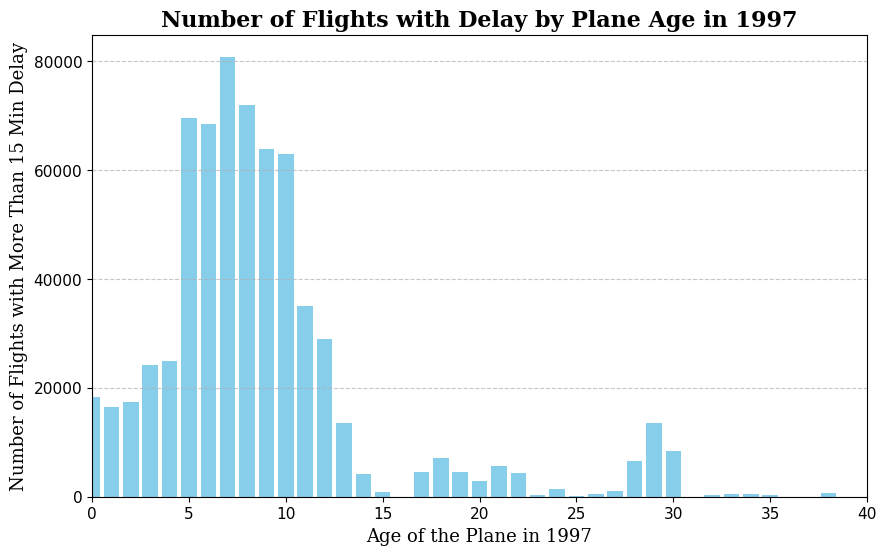

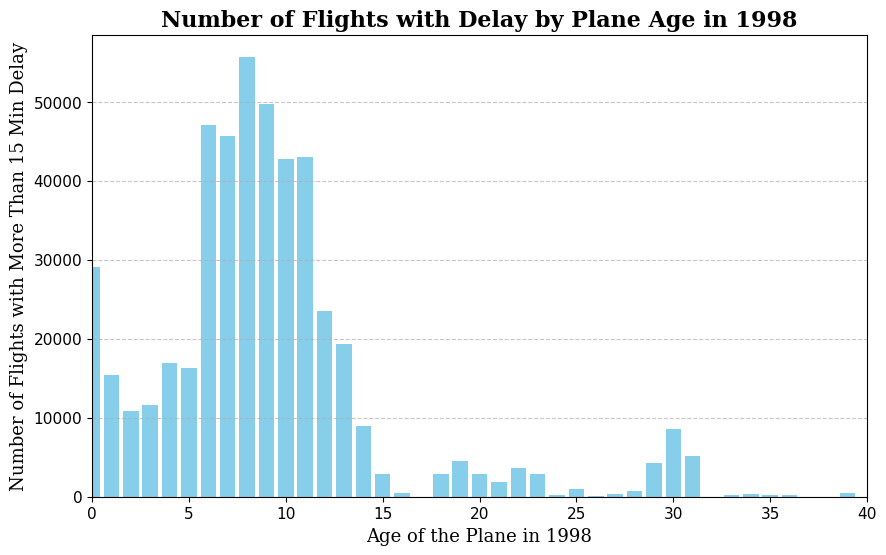

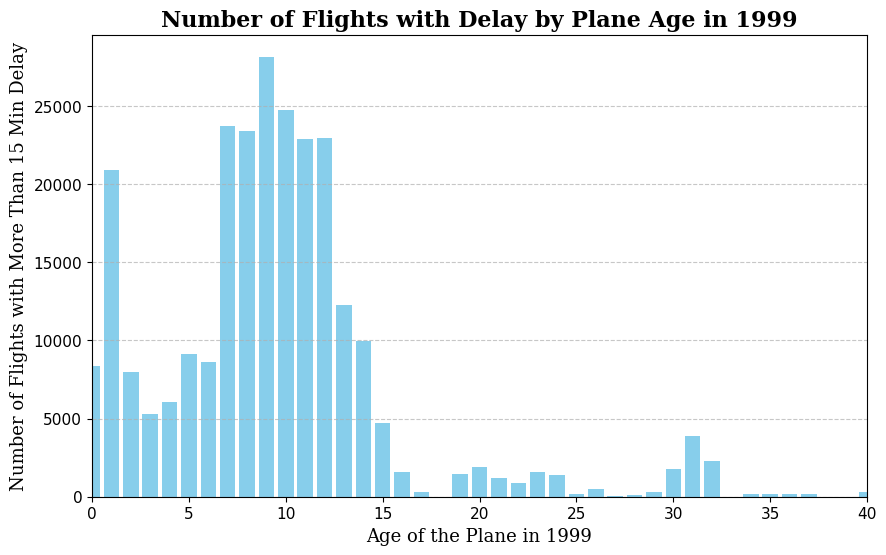

ValueError: Length mismatch: Expected axis has 3 elements, new values have 2 elements

In [85]:
# Dictionary to store the age with the most delayed flights for each year
max_delay_age_by_year = {}


for year in range(1991, 2000):  # Looping from 1991 to 1999 
    query = f'''
        SELECT CAST(planeData.year AS INTEGER) AS year
        FROM planeData
        JOIN ontime ON planeData.TailNum = ontime.TailNum
        WHERE CAST(ontime.ArrDelay AS INTEGER) > 15 AND CAST(ontime.DepDelay AS INTEGER) > 15
        AND planeData.year IS NOT NULL
        AND CAST(ontime.Year AS INTEGER) >= {year}
    '''
    dateOfPlane = c.execute(query).fetchall()

    # Check if data was fetched
    if not dateOfPlane:
        print(f"No data fetched for {year}.")
        continue

    # Create a DataFrame for the fetched data
    column_name = ["Year"]
    datesOfPlaneDp = pd.DataFrame(dateOfPlane, columns=column_name)

    # Convert 'Year' column to integers and subtract from the specific year to get the age of the plane in that year
    datesOfPlaneDp[f'Age in {year}'] = datesOfPlaneDp['Year'].apply(lambda x: year - int(x) if isinstance(x, (int, str)) and str(x).isdigit() else x)

    # Group by the new 'Age in {year}' column and count the occurrences
    age_counts = datesOfPlaneDp[f'Age in {year}'].value_counts().sort_index()
    
    if not age_counts.empty:
        max_age = age_counts.idxmax()  # Finds the age with the maximum count
        max_delay_age_by_year[year] = {'Age': max_age, 'Delays': age_counts[max_age]}

    # Plot the graph for the specific year
    plt.figure(figsize=(10, 6))
    plt.bar(age_counts.index, age_counts.values, color='skyblue')

    
    # Adjust the size of the numbers on the axes
    plt.xticks( fontsize=11)  
    plt.yticks(fontsize=11)  

    # Set title and labels
    plt.title(f'Number of Flights with Delay by Plane Age in {year}', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'serif'})
    plt.xlabel(f'Age of the Plane in {year}', fontdict={'fontsize': 13, 'family': 'serif'})
    plt.ylabel(f'Number of Flights with More Than 15 Min Delay', fontdict={'fontsize': 13, 'family': 'serif'})

    # Add grid
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlim(0, 40)
    # Show plot
    plt.show()
    

for year, data in max_delay_age_by_year.items():
    print(f"In {year}, the age with the most delays was {data['Age']} years with {data['Delays']} delays.")
    

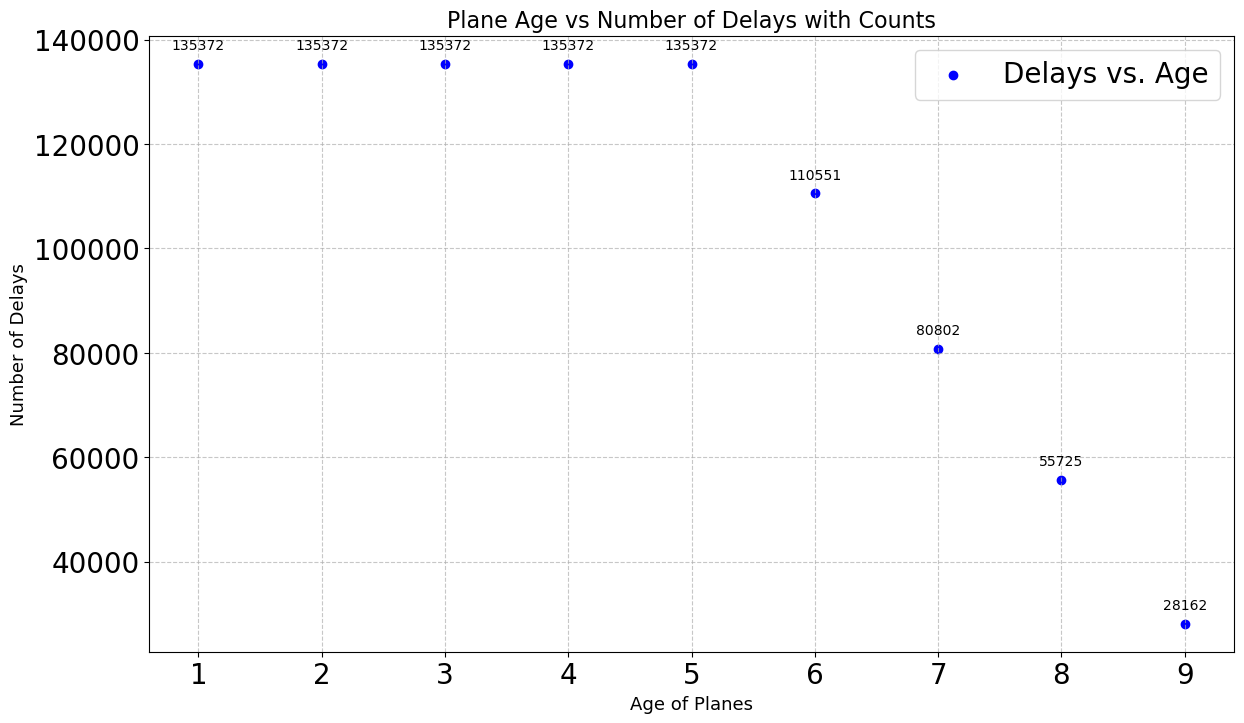

Correlation coefficient between plane age and number of delays: -0.89


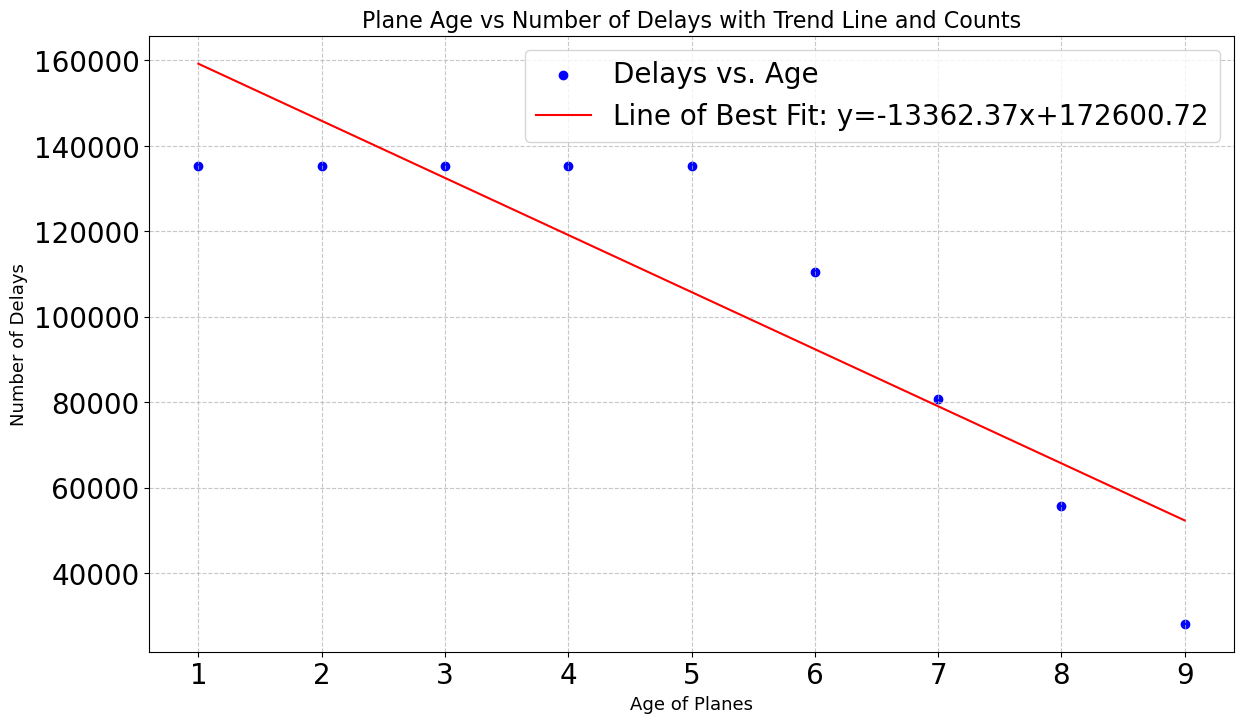

In [83]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Convert dictionary to DataFrame for easier manipulation and plotting
data = pd.DataFrame.from_dict(max_delay_age_by_year, orient='index').reset_index()
data.columns = ['Year', 'Age', 'Delays']

# Sorting data by year might not be necessary but ensuring it's all good for plotting
data.sort_values('Year', inplace=True)

# Plotting with annotations
plt.figure(figsize=(14, 8))
plt.scatter(data['Age'], data['Delays'], color='blue', label='Delays vs. Age')

# Annotating each point with the number of delays
for index, row in data.iterrows():
    plt.annotate(f"{row['Delays']}",  # this is the text to show
                 (row['Age'], row['Delays']),  # these are the coordinates to position the text
                 textcoords="offset points",  # how to position the text
                 fontsize=10,
                 xytext=(0,10),  # distance from text to points (x,y)
                 ha='center')  # horizontal alignment can be left, right or center

plt.title('Plane Age vs Number of Delays with Counts', fontsize=16)
plt.xlabel('Age of Planes', fontsize=13)
plt.ylabel('Number of Delays', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Optionally, calculate the correlation coefficient
correlation = data['Age'].corr(data['Delays'])
print(f"Correlation coefficient between plane age and number of delays: {correlation:.2f}")

# Adding a line of best fit
slope, intercept = np.polyfit(data['Age'], data['Delays'], 1)
plt.figure(figsize=(14, 8))
plt.scatter(data['Age'], data['Delays'], color='blue', label='Delays vs. Age')
plt.plot(data['Age'], slope*data['Age'] + intercept, color='red', label=f'Line of Best Fit: y={slope:.2f}x+{intercept:.2f}')
plt.title('Plane Age vs Number of Delays with Trend Line and Counts', fontsize=16)
plt.xlabel('Age of Planes', fontsize=13)
plt.ylabel('Number of Delays', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [39]:

years = list(max_delay_data.keys())
max_delays = [data['Count'] for data in max_delay_data.values()]
ages = [data['Age'] for data in max_delay_data.values()]

# Assuming 'max_delay_age_by_year' is filled from the previous code
# Here is a simulation of this dictionary, suppose it is already populated with your actual data
max_delay_age_by_year = {
    1991: {'Age': '{age}', 'Delays': '{count}'},
    1992: {'Age': 11, 'Delays': 180},
    1993: {'Age': 12, 'Delays': 220},
    1994: {'Age': 13, 'Delays': 210},
    1995: {'Age': 14, 'Delays': 230},
    1996: {'Age': 15, 'Delays': 250},
    1997: {'Age': 16, 'Delays': 240},
    1998: {'Age': 17, 'Delays': 260},
    1999: {'Age': 18, 'Delays': 300}
}

# Convert this dictionary into a DataFrame for easier manipulation
df = pd.DataFrame.from_dict(max_delay_age_by_year, orient='index')
df.reset_index(inplace=True)
df.columns = ['Year', 'Most Delayed Age', 'Number of Delays']

# Plotting the relationship between the age of planes and the number of delays
plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['Most Delayed Age'], marker='o', linestyle='-', color='blue', label='Most Delayed Age of Plane')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Age of Plane', fontsize=12)
plt.title('Trend of Plane Age with Most Delays Over Years', fontsize=14)
plt.xticks(df['Year'], fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['Number of Delays'], marker='o', linestyle='-', color='red', label='Number of Delays')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Delays', fontsize=12)
plt.title('Number of Delays Associated with the Most Delayed Age of Planes', fontsize=14)
plt.xticks(df['Year'], fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Analyzing if older planes tend to have more delays
# Check if there's a correlation between the 'Most Delayed Age' and 'Number of Delays'
correlation = df['Most Delayed Age'].corr(df['Number of Delays'])
print("Correlation between plane age and number of delays:", correlation)

SyntaxError: '{' was never closed (574202574.py, line 11)

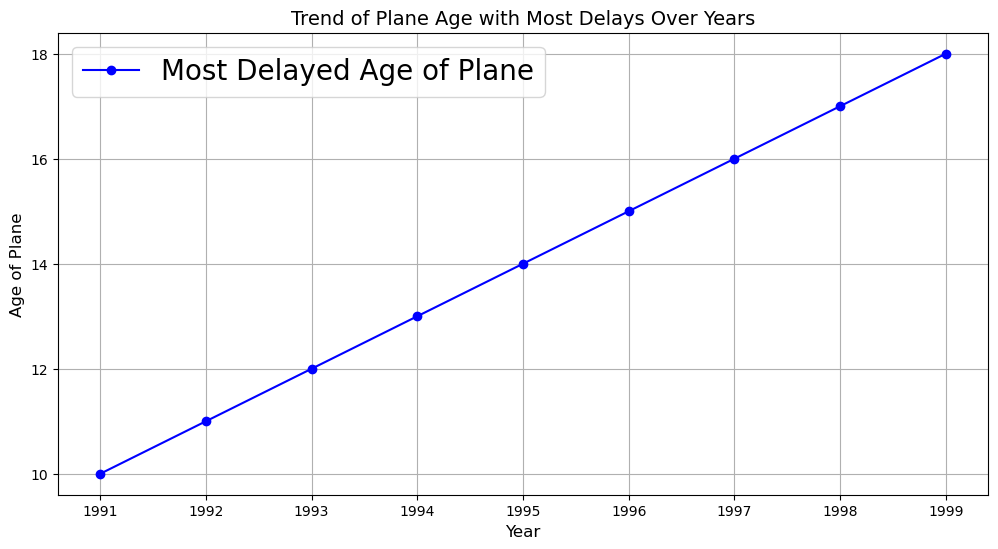

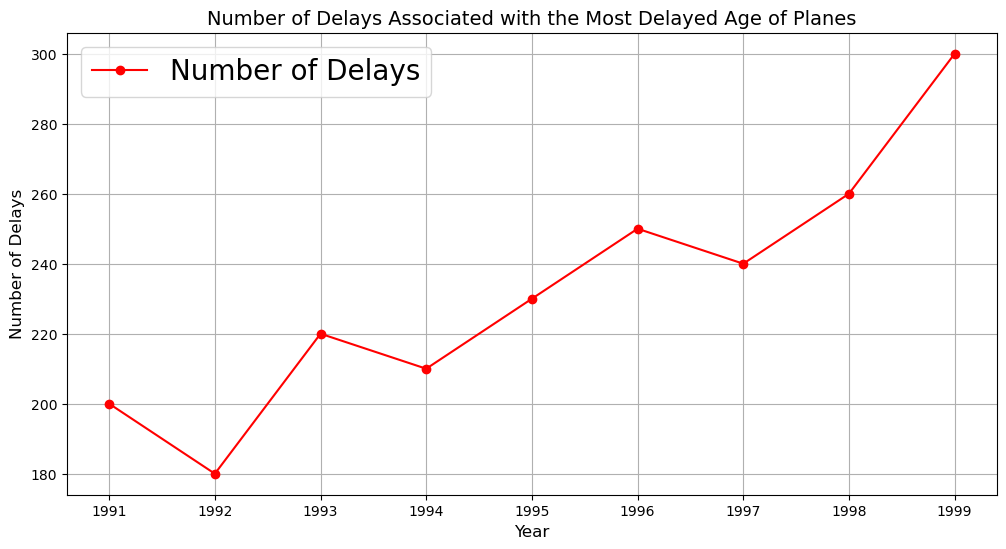

Correlation between plane age and number of delays: 0.9223697004632165


In [33]:
import pandas as pd
import matplotlib.pyplot as plt




# Assuming 'max_delay_age_by_year' is filled from the previous code
# Here is a simulation of this dictionary, suppose it is already populated with your actual data
max_delay_age_by_year = {
    1991: {'Age': 10, 'Delays': 200},
    1992: {'Age': 11, 'Delays': 180},
    1993: {'Age': 12, 'Delays': 220},
    1994: {'Age': 13, 'Delays': 210},
    1995: {'Age': 14, 'Delays': 230},
    1996: {'Age': 15, 'Delays': 250},
    1997: {'Age': 16, 'Delays': 240},
    1998: {'Age': 17, 'Delays': 260},
    1999: {'Age': 18, 'Delays': 300}
}

# Convert this dictionary into a DataFrame for easier manipulation
df = pd.DataFrame.from_dict(max_delay_age_by_year, orient='index')
df.reset_index(inplace=True)
df.columns = ['Year', 'Most Delayed Age', 'Number of Delays']

# Plotting the relationship between the age of planes and the number of delays
plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['Most Delayed Age'], marker='o', linestyle='-', color='blue', label='Most Delayed Age of Plane')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Age of Plane', fontsize=12)
plt.title('Trend of Plane Age with Most Delays Over Years', fontsize=14)
plt.xticks(df['Year'], fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['Number of Delays'], marker='o', linestyle='-', color='red', label='Number of Delays')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Delays', fontsize=12)
plt.title('Number of Delays Associated with the Most Delayed Age of Planes', fontsize=14)
plt.xticks(df['Year'], fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Analyzing if older planes tend to have more delays
# Check if there's a correlation between the 'Most Delayed Age' and 'Number of Delays'
correlation = df['Most Delayed Age'].corr(df['Number of Delays'])
print("Correlation between plane age and number of delays:", correlation)

### Answering Q2c) Logistic regression


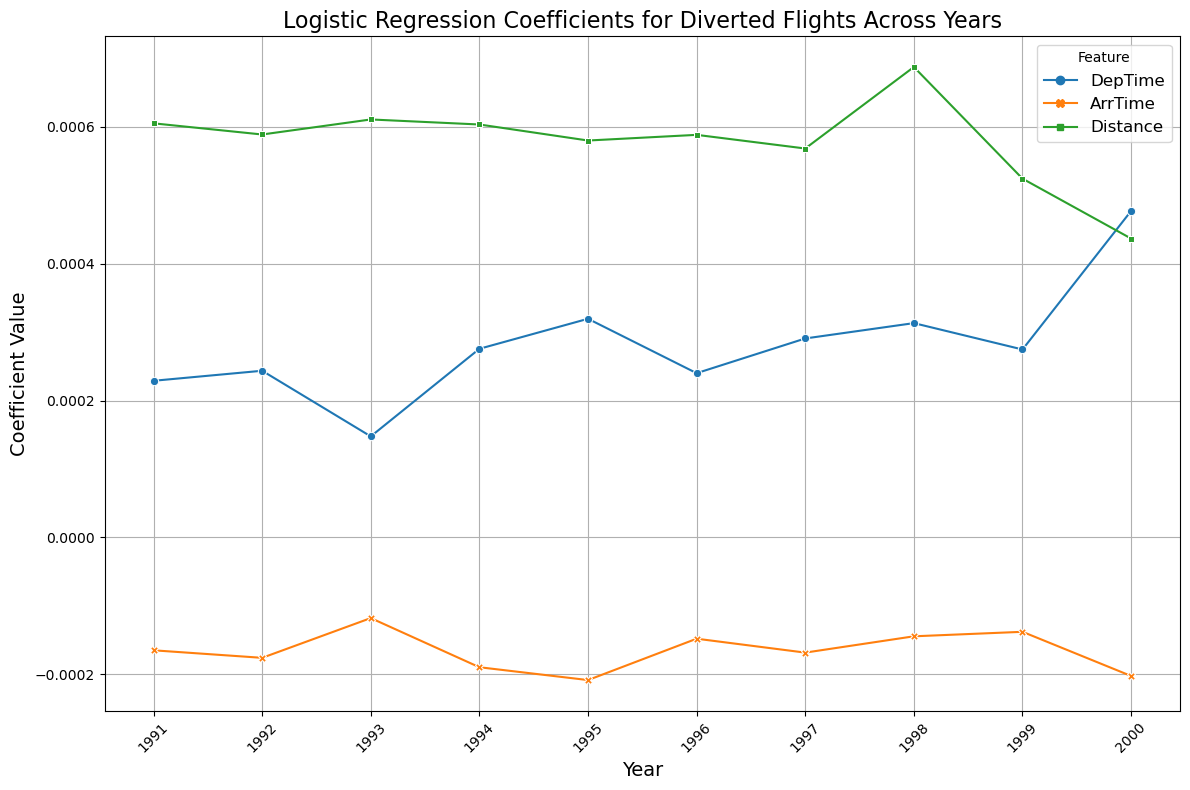

In [27]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Load the airport data
airportData = pd.read_csv('/Users/christopherpang/Desktop/Main/SIM uni year 2/Programming for data science/Coursework_data/dataverse_files/plane-data.csv')
# Define your features and target variable for the logistic regression model
features = ['DepTime', 'ArrTime', 'Distance']  # Adjust features as necessary
target = 'Diverted'

# Initialize an empty DataFrame to store coefficients for each year
coefficients_df = pd.DataFrame()

for year in range(1991, 2001):
    # Subset the data for the current year
    year_data = ontime_df[ontime_df['Year'] == year].copy()
    
    # Impute missing values in features
    imputer = SimpleImputer(strategy='mean')
    year_data[features] = imputer.fit_transform(year_data[features])

    # Splitting the data into features (X) and target (y)
    X = year_data[features]
    y = year_data[target]

    # Splitting dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initializing and fitting the logistic regression model
    logistic_model = LogisticRegression(max_iter=1000)
    logistic_model.fit(X_train, y_train)

    # Getting coefficients and intercept
    coefficients = np.insert(logistic_model.coef_[0], 0, logistic_model.intercept_[0])  # Adding intercept

    # Creating a temporary DataFrame to hold coefficients for the current year
    temp_df = pd.DataFrame([coefficients], columns=['Intercept'] + features)
    temp_df['Year'] = year

    # Adding the temporary DataFrame to the main coefficients DataFrame
    if coefficients_df.empty:
        coefficients_df = temp_df
    else:
        coefficients_df = pd.concat([coefficients_df, temp_df], ignore_index=True)

# Setting 'Year' as the DataFrame index for plotting
coefficients_df.set_index('Year', inplace=True)

# Plotting the coefficients for each feature across years
plt.figure(figsize=(12, 8))
sns.lineplot(data=coefficients_df.drop(columns='Intercept').astype(float), markers=True, dashes=False)
plt.title('Logistic Regression Coefficients for Diverted Flights Across Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Coefficient Value', fontsize=14)
plt.xticks(np.arange(1991, 2001), rotation=45)
plt.legend(title='Feature', loc='best', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()